# A computational building block approach towards multiscale architected materials analysis and design with application to hierarchical metal metamaterials    

### Markus J. Buehler
email: mbuehler@mit.edu  

Abstract: In this study we report a computational approach towards multiscale architected materials analysis and design. A particular challenge in modeling and simulation of materials, and especially the development of hierarchical design approaches, has been to identify ways by which complex multi-level material structures can be effectively modeled. One way to achieve this is to use coarse-graining approaches, where  physical relationships can be effectively described with reduced dimensionality. In this paper we report an integrated deep neural network architecture that first learns coarse-grained representations of complex hierarchical microstructure data via a discrete variational autoencoder and then utilizes an attention-based diffusion model solve both forward and inverse problems, including a capacity to solve degenerate design problems. As an application, we demonstrate the method in the analysis and design of hierarchical highly porous metamaterials within the context of nonlinear stress-strain responses to compressive deformation.  We validate the mechanical behavior and mechanisms of deformation using embedded-atom molecular dynamics simulations carried out for copper and nickel, showing good agreement with the design objectives.  

##### Reference: 

[1] M. Buehler, A computational building block approach towards multiscale architected materials analysis and design with application to hierarchical metal metamaterials , Modelling and Simulation in Materials Science and Engineering, 2023 

### This code consists of 3 models

This code consists of three models: Model 1 (VQ-VAE to encode hierarchical architected microstructures), Model 2 (diffusion model to predict hierarchical architected microstructures from a stress-strain response conditioning), and Model 3 (diffusion model to predict stress-strain response from a microstructure)

## Model 3: Attention-diffusion model to predict stress-strain response from microstructure

In [1]:
import os,sys
import math

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import shutil

In [2]:
from torchvision.utils import save_image, make_grid

In [3]:
import torch
#from imagen_pytorch import Unet, Imagen
from sklearn.model_selection import train_test_split

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

device='cuda:0'

In [5]:
from HierarchicalDesign import VectorQuantize, VQVAEModel, Encoder_Attn ,Decoder_Attn,count_parameters
from HierarchicalDesign import get_fmap_from_codebook


In [6]:
batch_size_=8

In [7]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

In [8]:
num_of_gpus = torch.cuda.device_count()
print(num_of_gpus)

1


In [9]:

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

#from tqdm import tqdm
from tqdm.autonotebook import tqdm

from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from sklearn.metrics import r2_score

print("Torch version:", torch.__version__) 
import matplotlib.pyplot as plt

import ast
import pandas as pd
import numpy as np
from einops import rearrange 
 
from torch.utils.data import DataLoader,Dataset
from torchvision.io import read_image
import pandas as pd
from sklearn.model_selection import train_test_split

from PIL import Image
import time
to_pil = transforms.ToPILImage()

from torchvision.utils import save_image, make_grid


Torch version: 2.0.0+cu117


In [10]:
def exists(val):
    return val is not None

### Define and load VQ-VAE

In [11]:
im_res_VAE=512 
im_res_final=im_res_VAE

###########
hidden_dim = 16   #this is how much depth the sequence will have

num_codebook_vectors=128 
embedding_dim = 256 #for codebook

output_dim = 3
input_dim = 3

chann_enc=  [64, 64, 64, 128, 128, 128, 256, 256]  
chann_dec= [256, 256, 256, 128, 64, 64, 64] 

codebook = VectorQuantize(
            dim = hidden_dim,
            codebook_dim = embedding_dim,
            codebook_size = num_codebook_vectors,
            decay = 0.9,
            commitment_weight = 1.,
            kmeans_init = True,
            accept_image_fmap = True,
            use_cosine_sim = True,
            orthogonal_reg_weight = 2., #0.
        )

###########################################################################
encoder = Encoder_Attn( image_channels=input_dim, latent_dim=hidden_dim,
                      channels = chann_enc, 
                      start_resolution_VAE_encoder=512,
                 attn_resolutions_VAE_encoder = [16],
                 num_res_blocks_encoder=2,
                      )
decoder = Decoder_Attn( image_channels=input_dim, latent_dim=hidden_dim, 
                       channels = chann_dec,
                       attn_resolutions_VAE_decoder=[16],
                 start_resolution_VAE_decoder= 16, 
                 num_res_blocks_VAE_decoder=3,
                      )
###########################################################################
VQVAEmodel = VQVAEModel(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(device)
count_parameters(VQVAEmodel)

Final resolution of encoder (must be start resolution of decoder):  16
Final resolution of decoder:  512
----------------------------------------------------------------------------------------------------
Total parameters:  28904291  trainable parameters:  28904291
----------------------------------------------------------------------------------------------------


#### Test VQ-VAE and define some variables 

In [12]:
#Test model and shapes
print ("Image resolution: ", im_res_VAE,  "x", im_res_VAE)
images = torch.randn(4, 3, im_res_VAE, im_res_VAE).cuda()

with torch.no_grad():
    z, indices  =  VQVAEmodel.encode_z(images, )
print ("z ", z.shape )
print ("infices ", indices.shape)

with torch.no_grad():
    images_hat =  VQVAEmodel.decoder(z,  )
print ("image  snapped shape ", images_hat.shape)

with torch.no_grad():
    images_hat_snapped, z_quant =  VQVAEmodel.decode_snapped(z,  )

    print ("image_hat snapped shape ", images_hat_snapped.shape)
print ("z quant ", z_quant.shape)

size_VAE=z.shape [1]
z_reshaped=torch.reshape(z, (z.shape[0],z.shape[1],z.shape[2]**2))

fmap_lin = z.shape[2]
print (f"VAE will produce sequences of shape (b,  {z_reshaped.shape})")

Image resolution:  512 x 512
z  torch.Size([4, 16, 8, 8])
infices  torch.Size([4, 8, 8])
image  snapped shape  torch.Size([4, 3, 512, 512])
image_hat snapped shape  torch.Size([4, 3, 512, 512])
z quant  torch.Size([4, 16, 8, 8])
VAE will produce sequences of shape (b,  torch.Size([4, 16, 64]))


In [13]:
VQVAEmodel.load_state_dict(torch.load(f'./VQ_VAE_results/model-epoch_128.pt'))

<All keys matched successfully>

In [14]:
def sample_VAE (model, test_loader, samples = 16, fname1 = None, fname2 = None):
    model.eval()

    with torch.no_grad():

        for batch_idx, (_, x) in enumerate(tqdm(test_loader)):

            x = x.to(device)
        
            x_hat, indices, commitment_loss,    = model(x)

            with torch.no_grad():
                x_enc =model.encode(x)
            
            with torch.no_grad():
                z, indices=model.encode_z(x)
            
            with torch.no_grad():
                x_hat_snapped, z_quant =  model.decode_snapped(z,  )

            break
    samples= min([samples, x.shape[0]])
    
    x_hat=unscale_image(x_hat)
    x_hat_snapped=unscale_image(x_hat)
    x=unscale_image(x)

    draw_sample_image(x[:samples], "Ground-truth images", fname1)
    draw_sample_image(x_hat[:samples], "Reconstructed images", fname2)
    draw_sample_image(x_hat_snapped[:samples], "Reconstructed images, snapped", fname2)
        
    return

In [15]:
def draw_sample_image(x, postfix, fname=None, dpi=600,padding=0):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=padding, normalize=True), (1, 2, 0)))
    if fname != 0:
        plt.savefig(fname, dpi=dpi)
    plt.show()

### Load dataset

In [16]:
from torch.utils.data import DataLoader,Dataset
import pandas as pd
import seaborn as sns

In [17]:
import torchvision
 
import matplotlib.pyplot as plt
import numpy as np
 
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from functools import partial, wraps

In [18]:

from sklearn.preprocessing import RobustScaler

In [19]:
from PIL import Image
import ast
import pandas as pd
import numpy as np

def scale_image(image2):
    return image2 * 2. - 1.0
 
def unscale_image(image2):
    image2=(image2 +1. )/ 2. 
    image2=image2.clamp(0, 1)
    return image2
 
data_dir = '../'
class ImageDataset_ImagePairs(Dataset):
    def __init__(self,X_data,paths2,transform):
       
        self.X_data = X_data
        
        self.paths2=list(paths2)
        self.transform=transform
         
    def __len__(self):
        return len(self.paths2)

    def __getitem__(self,index):

      
        image1= self.X_data[index]

        im2_pil = Image.open(data_dir+self.paths2[index]).convert('RGB')

        image2=self.transform(im2_pil)
        image2=scale_image(image2)    
      
        return (image1, image2)
def ImagePairs_load_split_train_test(csvfile, valid_size = .2, im_res=256, batch_size_=16, max_l=32,
                                    X_min=None, X_max=None):
    train_transforms = transforms.Compose([#transforms.RandomRotation(30),  # data augmentations are great
                                       #transforms.RandomResizedCrop(224),  # but not in this case of map tiles
                                       #transforms.RandomHorizontalFlip(),
                                        transforms.RandomHorizontalFlip(),
                                        #transforms.RandomVerticalFlip(),
                                    transforms.Resize((im_res,im_res)),
                                           #transforms.Normalize([0.485, 0.456, 0.406],  
                                           #                  [0.229, 0.224, 0.225]),
                                       transforms.ToTensor(),
                                           #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                           #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                       ])
    test_transforms = transforms.Compose([#transforms.RandomRotation(30),  # data augmentations are great
                                       #transforms.RandomResizedCrop(224),  # but not in this case of map tiles
                                        transforms.RandomHorizontalFlip(),
                                       # transforms.RandomVerticalFlip(),
                                        #transforms.RandomHorizontalFlip(),
                                        transforms.Resize((im_res,im_res)),
                                           #transforms.Normalize([0.485, 0.456, 0.406],  
                                           #                  [0.229, 0.224, 0.225]),
                                       #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                       transforms.ToTensor(),
                                          # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                          #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                       ])

    df=pd.read_csv(csvfile)
     
    imgpair=df["microstructure"]
    
    x=df['stresses']
    
    xs=[]
    for xi in x:
        xentry=ast.literal_eval(xi)
        xs.append(xentry[:max_l])
    X=np.asarray(xs)
    
    if X_min==None:
        X_min=np.min(X)
    else:
        print ("use provided X_min", X_min)
    if X_max==None:
        X_max=np.max(X)
    else:
        print ("use provided X_max", X_max)
    
    X=(X-X_min)/(X_max-X_min)*2-1 #Normalize range -1 to 1
    
    print ("Check X after norm  ", np.min(X), np.max(X))
    
    X=torch.from_numpy(X).float()
    if valid_size>0:
       
        X_train, X_test, y_train, y_test =train_test_split(X,imgpair,test_size=valid_size, random_state=451)
    else:
        train_dataset = ImageDataset_ImagePairs(X, imgpair,test_transforms)
        trainloader = DataLoader(dataset=train_dataset, batch_size=batch_size_, shuffle=False)
     
        return trainloader, None, X_max, X_min
    
    train_data=ImageDataset_ImagePairs(X_train,y_train,train_transforms)
    test_data=ImageDataset_ImagePairs(X_test,y_test,test_transforms)
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_)

    testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_)
    return trainloader, testloader, X_max, X_min

csvfile = './shc_09_raw_wimagename_5_thick.csv'

train_loader, test_loader, X_max, X_min = ImagePairs_load_split_train_test(csvfile, .1, 
                                                                           im_res=im_res_VAE,
                                                                           batch_size_=batch_size_, 
                                                                           max_l=32)

print ("Number of training batches: ", len(train_loader), "batch size= ", batch_size_, "total: ",len(train_loader)*batch_size_ )
print ("Number of test batches: ", len(test_loader), "batch size= ", batch_size_, "total: ",len(test_loader)*batch_size_)

print("TOTAL images (account for full batches): ", len(train_loader)*batch_size_+len(test_loader)*batch_size_ )

print ("X_max", X_max, "X_min ", X_min)

Check X after norm   -1.0 1.0
Number of training batches:  163 batch size=  8 total:  1304
Number of test batches:  19 batch size=  8 total:  152
TOTAL images (account for full batches):  1456
X_max 1.42978730046296 X_min  -0.0086872168352131


  0%|          | 0/19 [00:00<?, ?it/s]

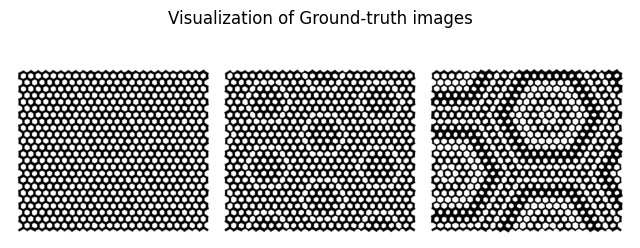

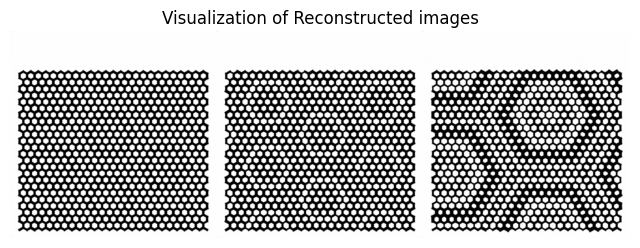

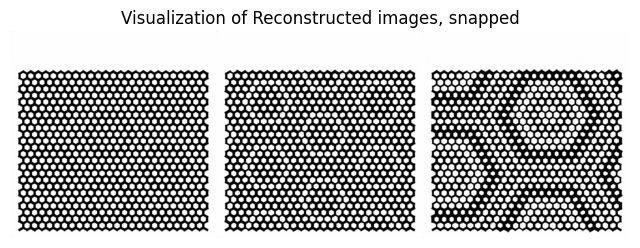

In [20]:
sample_VAE (VQVAEmodel, test_loader, fname1 =f'or_test.png', fname2=f'rec_test.png',samples = 3)

## Helper functions and build model

In [21]:
def sample_sequence (model,
                X=[[10, 10, 8, 3, 13, 13, 14, 7, 3, 10 ]],
                 flag=0,
                     cond_scales=1.,foldproteins=False,
                     seed=None,plot_original_data=False,GT =None,
               ):
    steps=0
    e=flag

    if seed !=None:
        print ("Set seed to: ", seed)
        seed_everything(seed)
    
    print (f"Producing {len(X)} samples...")

    X=torch.Tensor(X)
    X=(X-X_min)/(X_max-X_min)*2-1 #Normalize range -1 to 1
    for iisample in range (len (X)):
    
        
        X_cond= (X[iisample] ).to(device).unsqueeze (0)
        
        result=model.sample ( X_cond,stop_at_unet_number=train_unet_number ,
                                 cond_scale=cond_scales )
            
      
        
        if plot_original_data:
            
            cond_unscaled=(X_cond[0,:].cpu().detach().numpy()+1)/2.*(X_max-X_min)+X_min
            
            plt.plot (cond_unscaled,label= f'Required stress-strain data')
            plt.ylim ((0, 1.1))
           
            plt.legend()
            
            fname4= prefix+ f"input_to_samples_{e}_{steps}.jpg"
            plt.savefig(fname4, dpi=300)   
            plt.show()
    
        
        result=torch.reshape(result, (result.shape[0],result.shape[1], sqer_z,sqer_z))
    
        model.imagen.vit_vae.eval()
        
        with torch.no_grad():
            
            result,_ =  model.imagen.vit_vae.decode_snapped(result,  )
            result=unscale_image(result)
        
        fname2=prefix+ f"sampld_from_X_{flag}_condscale-{str (cond_scales)}_{e}_{steps}.jpg"
        

        draw_sample_image(result[0,:], "Predicted microstructure", fname2)  

 
        steps=steps+1
       
    reset_seed()
    
def draw_sample_image(x, postfix, fname=None):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=0, normalize=True), (1, 2, 0)))
    if fname != None:
        plt.savefig(fname, dpi=300)
    plt.show()
    
def sample_loop (model,
                train_loader,
                cond_scales=[7.5], #list of cond scales - each sampled...
                num_samples=2, #how many samples produced every time tested.....
                timesteps=100,
                 flag=0,foldproteins=False,
                  seed=None,save_ind_files=False,
                 plot_structure=False,plot_original_data=False,do_forward=False,number_batches=1,strain=None,
                 return_stresses=False, 
               ):
    steps=0
    e=flag
    if return_stresses:
        stresses_list =[]
        GT_stresses_list =[]
        
        image_list =[]
    if seed !=None:
        print ("Set seed to: ", seed)
        seed_everything(seed)
        
    for item  in train_loader:

            X_train_batch= item[1].to(device)
            y_train_batch=item[0].to(device)

            GT=(y_train_batch.cpu().detach()+1.)/2.*(X_max-X_min)+X_min 
        
            num_samples = min (num_samples,y_train_batch.shape[0] )
            print (f"Producing {num_samples} samples..., batch size ={y_train_batch.shape[0]}")
 
            for iisample in range (len (cond_scales)):
                
                fname1=  prefix+ f"GT_samples_{e}_{steps}.png"
                draw_sample_image(X_train_batch[:num_samples,:].cpu().detach() , "Input images", fname1)                
               
                model.imagen.vit_vae.eval()
                
                with torch.no_grad():
                   
                    X_train_batch  =  model.imagen.vit_vae.encode(X_train_batch, )


                
                X_train_batch=torch.reshape(X_train_batch, (X_train_batch.shape[0],
                                                            X_train_batch.shape[1],
                                                            sqer_z**2))                    
                    
                result=model.sample ( X_train_batch,stop_at_unet_number=train_unet_number ,
                                         cond_scale=cond_scales[iisample])

                
                result=(result.cpu().detach() +1.)/2.*(X_max-X_min)+X_min
                
                fig, axs = plt.subplots(1, num_samples,figsize=( 4.5*num_samples,3))
                for iu in range (num_samples):
                    
                    if strain==None:
                        axs[ iu].plot (result[iu,0,:] ,
                                        label= f'Predicted, spl {iu}')
                        
                        axs[ iu].plot (GT[iu,:] ,
                                        label= f'GT, spl {iu}')
                        
                    else:
                        lstrai=min (len (strain),result[iu,0,:].shape[0], GT[iu,:].shape[0] )
                        
                        axs[ iu].plot (strain[:lstrai], result[iu,0,:lstrai] ,
                            label= f'Predicted, spl {iu}')
                        axs[ iu].plot (strain[:lstrai], GT[iu,:lstrai] ,
                            label= f'GT, spl {iu}')
                        
                        axs[ iu].set_xlabel('Strain')
                        axs[ iu].set_ylabel('Stress $\sigma$ (MPa)')
                    axs[ iu].set_aspect(0.5, adjustable='box')
                    
                    axs[ iu].set_ylim([0,1.2])
                    axs[ iu].legend()
                    
                    if return_stresses:
                        GT_stresses_list.append( GT[iu,:lstrai] )
                        
                        stresses_list.append( result[iu,0,:lstrai] ) 
                       

                plt.savefig(f'{prefix}/stress_strain_pred__{e}_{steps}.svg', dpi=300)#, quality = 95)  
                plt.savefig(f'{prefix}/stress_strain_pred__{e}_{steps}.png', dpi=300)#, quality = 95)  
                plt.show()
              
                     
            steps=steps+1
            if steps>=number_batches:
                if return_stresses:                 
                    return GT_stresses_list, stresses_list, image_list   
                else:
                    break
    if return_stresses:                 
        return GT_stresses_list, stresses_list, image_list   
    else:
        return                                          
                                              
def sample_from_image (model, fname, strain=None, GT=None, flag=0,cond_scales=[1.]):
    
    steps=flag

    image_transforms = transforms.Compose([#transforms.RandomRotation(30),  # data augmentations are great
                                           #transforms.RandomResizedCrop(224),  # but not in this case of map tiles
                                           # transforms.RandomHorizontalFlip(),
                                           # transforms.RandomVerticalFlip(),
                                            #transforms.RandomHorizontalFlip(),
                                            transforms.Resize((im_res_final,im_res_final)),
                                               #transforms.Normalize([0.485, 0.456, 0.406],  
                                               #                  [0.229, 0.224, 0.225]),
                                           #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                           transforms.ToTensor(),
                                              # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                              #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                           ])



    im2_pil = Image.open(fname).convert('RGB')#Image.fromarray(image2)

    image2=image_transforms(im2_pil).unsqueeze (0)
     
    fname1=  prefix+ f"GT_samples_{steps}.png"
    draw_sample_image(image2 , "Input images", fname1) 
    
    image2=scale_image(image2) 
    
    model.imagen.vit_vae.eval()

    
    with torch.no_grad():
       
        X_train_batch  =  model.imagen.vit_vae.encode(image2.to(device), )

    X_train_batch=torch.reshape(X_train_batch, (X_train_batch.shape[0],
                                                X_train_batch.shape[1],
                                                sqer_z**2))                    
    num_samples=1
    for iisample in range (len (cond_scales)):
        
        result=model.sample ( X_train_batch,stop_at_unet_number=train_unet_number ,
                                 cond_scale=cond_scales[iisample])
        
        result=(result.cpu().detach() +1.)/2.*(X_max-X_min)+X_min

        fig, axs = plt.subplots(1, num_samples,figsize=( 4.5*num_samples,3))
        for iu in range (num_samples):

            if strain==None:
                plt.plot (result[iu,0,:] ,
                                label= f'Predicted, spl {iu}')
                if exists(GT):
                    plt.plot (GT[iu,:] ,
                                label= f'GT, spl {iu}')
              
            else:
                lstrai=min (len (strain),result[iu,0,:].shape[0] )
                plt.plot (strain[:lstrai], result[iu,0,:lstrai] ,
                    label= f'Predicted, spl {iu}')
                if exists (GT):
                    plt.plot (strain[:lstrai], GT[iu,:lstrai] ,
                        label= f'GT, spl {iu}')

                plt.xlabel('Strain')
                plt.ylabel('Stress $\sigma$ (MPa)')

            plt.ylim( (0,1.2) )
            plt.legend()
                                   

In [22]:
def train_loop (model,
                train_loader,
                test_loader,
                optimizer=None,
                print_every=10,
                epochs= 300,
                start_ep=0,
                start_step=0,
                train_unet_number=1,
                print_loss=1000,
                trainer=None,
                plot_unscaled=False,
                max_batch_size=4,
                save_model=False,
                cond_scales=[7.5], #list of cond scales - each sampled...
                num_samples=4, #how many samples produced every time tested.....
                foldproteins=False,
                seed=None,strain=None,
                val_loader = None,save_ind_files=False,
                train_loader_valgen=None,
                 
               ):
    
    if not exists (trainer):
        if not exists (optimizer):
            print ("ERROR: If trainer not used, need to provide optimizer.")
    if exists (trainer):
        print ("Trainer provided... will be used")
    steps=start_step
    

    loss_total=0
    for e in range(1, epochs+1):
            start = time.time()

            torch.cuda.empty_cache()
            print ("######################################################################################")
            start = time.time()
            print ("NOW: Training epoch: ", e+start_ep)

            # TRAINING
            train_epoch_loss = 0
            model.train()
            
            print ("Loop over ", len(train_loader), " batches (print . every ", print_every, " steps)")

            for item  in train_loader:

                X_train_batch= item[1].to(device)

                y_train_batch=item[0].to(device)
                
                model.imagen.vit_vae.eval()
                
                with torch.no_grad():
                    X_train_batch  =  model.imagen.vit_vae.encode(X_train_batch, )
                    
                X_train_batch=torch.reshape(X_train_batch, (X_train_batch.shape[0],
                                                            X_train_batch.shape[1],
                                                            sqer_z**2))
                
 
                y_train_batch=y_train_batch.unsqueeze(1)
                
                
                if exists (trainer):
                    loss = trainer(
                            X_train_batch, y_train_batch,
                            unet_number=train_unet_number,
                            max_batch_size = max_batch_size,    # auto divide the batch of 64 up into batch size of 4 and accumulate gradients, so it all fits in memory
                        )
                    trainer.update(unet_number = train_unet_number)

                else:
                    optimizer.zero_grad()
                    loss=model ( X_train_batch, y_train_batch ,unet_number=train_unet_number)
                    loss.backward( )
                   
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

                    optimizer.step()

                loss_total=loss_total+loss.item()


                if steps % print_every == 0:
                    print(".", end="")

                if steps>0:
                    if steps % print_loss == 0:

                        norm_loss=loss_total/print_loss
                        print (f"\nTOTAL LOSS at epoch={e+start_ep}, step={steps}: {norm_loss}")

                        loss_list.append (norm_loss)
                        loss_total=0

                        plt.plot (loss_list, label='Loss')
                        plt.legend()

                        outname = prefix+ f"loss_{e}_{steps}.jpg"
                        plt.savefig(outname, dpi=200)
                        plt.show()
                        
                        
                        sample_loop (model,
                            test_loader,
                            cond_scales=cond_scales,
                            num_samples=num_samples,
                            timesteps=64,
                                    flag=steps,foldproteins=foldproteins,seed=seed,
                                     strain=strain,save_ind_files=save_ind_files,
                                    )   
                        if val_loader !=None:
                            sample_loop (model,
                                val_loader ,
                                cond_scales=[1],#[7.5], #list of cond scales - each sampled...
                                num_samples=4, #how many samples produced every time tested.....
                                timesteps=64,
                                        flag=steps, plot_structure=True, plot_original_data=True,do_forward=False,
             number_batches=4, strain=strain, save_ind_files=save_ind_files,
                                    )
                        if train_loader_valgen !=None:
                            sample_loop (model,
                                train_loader_valgen ,
                                cond_scales=[1],#[7.5], #list of cond scales - each sampled...
                                num_samples=8, #how many samples produced every time tested.....
                                timesteps=64,
                                        flag=940003, plot_structure=True, plot_original_data=True,do_forward=False,
                 number_batches=10, strain=strain, save_ind_files=True,
                                        )

                if steps>0:
                    if save_model and steps % print_loss==0: #steps % print_loss == 0:
                        fname=f"{prefix}trainer_save-model-epoch_{e+start_ep}.pt"
                        trainer.save(fname)
                        fname=f"{prefix}statedict_save-model-epoch_{e+start_ep}.pt"
                        torch.save(model.state_dict(), fname)
                        print (f"Model saved: ")
                    
                steps=steps+1
                                         
            print (f"\n\n-------------------\nTime for epoch {e+start_ep}={(time.time()-start)/60}\n-------------------")
            

### Define paths, model, etc.

In [25]:
def sample_sequence (model,
                X=[[10, 10, 8, 3, 13, 13, 14, 7, 3, 10 ]],
                 flag=0,
                     cond_scales=1.,foldproteins=False,
                     seed=None,plot_original_data=False,GT =None,
               ):
    steps=0
    e=flag

    if seed !=None:
        print ("Set seed to: ", seed)
        seed_everything(seed)
    

    #num_samples = min (num_samples,y_train_batch.shape[0] )
    print (f"Producing {len(X)} samples...")
    
    print ('Device: ', device)
    X=torch.Tensor(X)
    X=(X-X_min)/(X_max-X_min)*2-1 #Normalize range -1 to 1
    for iisample in range (len (X)):
        
        
        
        X_cond= (X[iisample] ).to(device).unsqueeze (0)
        
        print (X_cond.shape)
        result=model.sample ( X_cond,stop_at_unet_number=train_unet_number ,
                                 cond_scale=cond_scales )
            
        #result=torch.round(result*ynormfac)
        
        if plot_original_data:
            
            cond_unscaled=(X_cond[0,:].cpu().detach().numpy()+1)/2.*(X_max-X_min)+X_min
            
            plt.plot (cond_unscaled,label= f'Required stress-strain data')
            plt.ylim ((0, 1.1))
            #plt.plot (GT[samples,0,:],label= f'GT {0}')
            plt.legend()
            
            fname4= prefix+ f"input_to_samples_{e}_{steps}.jpg"
            plt.savefig(fname4, dpi=300)   
            plt.show()
    
        #y_data=(y_data-ydata_min)/(ydata_max-ydata_min)*2-1 #Normalize range -1 to 1
        #result=(result+1)/2.*(ydata_max-ydata_min)+ydata_min
        #result=torch.round(result)
    
        #result=result.squeeze(1)
                
        #result=result[:,:latent_dim]
        #print (result.shape)
        #print (result.shape)
        result=torch.reshape(result, (result.shape[0],result.shape[1], sqer_z,sqer_z))
        #print (result.shape)
        
        
        model.imagen.vit_vae.eval()
        with torch.no_grad():
            
            result,_ =  model.imagen.vit_vae.decode_snapped(result,  )
            result=unscale_image(result)
        
        
        
        
        
        
        

        fname2=prefix+ f"sampld_from_X_{flag}_condscale-{str (cond_scales)}_{e}_{steps}.jpg"
        

        draw_sample_image(result[0,:], "Predicted microstructure", fname2)  
    
        #plt.plot (result[0,0,:].cpu().detach().numpy(),label= f'Predicted')
        #plt.plot (GT[samples,0,:]*ynormfac,label= f'GT {0}')
        #plt.legend()

        #outname = prefix+ f"sampld_from_X_{flag}_condscale-{str (cond_scales)}_{e}_{steps}.jpg"
        #plt.title (f"Sample {samples}, cond scale={str (cond_scales[iisample])}")
        #plt.savefig(outname, dpi=200)
        #plt.show ()
        
       # generate_from_gene (genes=[result[0,0,:].cpu().detach().numpy()], dest_dir=f'.{prefix}/gene_output/')
 
        steps=steps+1
        #if steps>num_samples:
        #    break
    reset_seed()

In [26]:
def draw_sample_image(x, postfix, fname=None):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=0, normalize=True), (1, 2, 0)))
    if fname != None:
        plt.savefig(fname, dpi=300)
    plt.show()

In [27]:
def sample_loop (model,
                train_loader,
                cond_scales=[7.5], #list of cond scales - each sampled...
                num_samples=2, #how many samples produced every time tested.....
                timesteps=100,
                 flag=0,foldproteins=False,
                  seed=None,save_ind_files=False,
                 plot_structure=False,plot_original_data=False,do_forward=False,number_batches=1,strain=None,
                 return_stresses=False, 
               ):
    steps=0
    e=flag
    if return_stresses:
        stresses_list =[]
        GT_stresses_list =[]
        
        image_list =[]
    if seed !=None:
        print ("Set seed to: ", seed)
        seed_everything(seed)
        
    for item  in train_loader:


            X_train_batch= item[1].to(device)
            y_train_batch=item[0].to(device)

            #_,_,_,y_train_batch =  vit_vae(y_train_batch, )

            GT=(y_train_batch.cpu().detach()+1.)/2.*(X_max-X_min)+X_min 
            
            
            print (X_train_batch.shape, y_train_batch.shape)
            num_samples = min (num_samples,y_train_batch.shape[0] )
            print (f"Producing {num_samples} samples..., batch size ={y_train_batch.shape[0]}")
 

            for iisample in range (len (cond_scales)):
        
                #cond_unscaled=(X_train_batch.cpu().detach().numpy()+1)/2.*(X_max-X_min)+X_min
            
                print ("start sampling")
                
                fname1=  prefix+ f"GT_samples_{e}_{steps}.png"
                draw_sample_image(X_train_batch[:num_samples,:].cpu().detach() , "Input images", fname1)                
                #result=torch.reshape(X_train_batch, (result.shape[0],result.shape[1],sqer_z,sqer_z))
                model.imagen.vit_vae.eval()
                
                with torch.no_grad():
                    #X_train_batch,_ =  model.imagen.vit_vae.encode(X_train_batch, ) ###################HERE UPDATE
                    
                    X_train_batch  =  model.imagen.vit_vae.encode(X_train_batch, )


                
                X_train_batch=torch.reshape(X_train_batch, (X_train_batch.shape[0],
                                                            X_train_batch.shape[1],
                                                            sqer_z**2))                    
                    
                result=model.sample ( X_train_batch,stop_at_unet_number=train_unet_number ,
                                         cond_scale=cond_scales[iisample])
                print ("result and GT shape: " , result.shape, GT.shape)
                #result=result.squeeze(1)
                
                #result=result[:,:latent_dim]
                #print (result.shape)
                

                
                #result=unscale_image(result)
                #GT=unscale_image(GT)
                print ("X_train_batch ", X_train_batch.shape)
                
                result=(result.cpu().detach() +1.)/2.*(X_max-X_min)+X_min
                
                fig, axs = plt.subplots(1, num_samples,figsize=( 4.5*num_samples,3))
                for iu in range (num_samples):
                    
                    if strain==None:
                        axs[ iu].plot (result[iu,0,:] ,
                                        label= f'Predicted, spl {iu}')
                        
                        axs[ iu].plot (GT[iu,:] ,
                                        label= f'GT, spl {iu}')
                        #axs[ iu].set_aspect('equal')
                    else:
                        lstrai=min (len (strain),result[iu,0,:].shape[0], GT[iu,:].shape[0] )
                        print ("Length =" , lstrai)
                        axs[ iu].plot (strain[:lstrai], result[iu,0,:lstrai] ,
                            label= f'Predicted, spl {iu}')
                        axs[ iu].plot (strain[:lstrai], GT[iu,:lstrai] ,
                            label= f'GT, spl {iu}')
                        
                        axs[ iu].set_xlabel('Strain')
                        axs[ iu].set_ylabel('Stress $\sigma$ (MPa)')
                    axs[ iu].set_aspect(0.5, adjustable='box')
                    
                    axs[ iu].set_ylim([0,1.2])
                    axs[ iu].legend()
                    
                    if return_stresses:
                        GT_stresses_list.append( GT[iu,:lstrai] )
                        
                        stresses_list.append( result[iu,0,:lstrai] ) 
                        #image_list.append(fname2)                        


                
                #plt.plot (GT[samples,0,:],label= f'GT {0}')
                #plt.legend()
                plt.savefig(f'{prefix}/stress_strain_pred__{e}_{steps}.svg', dpi=300)#, quality = 95)  
                plt.savefig(f'{prefix}/stress_strain_pred__{e}_{steps}.png', dpi=300)#, quality = 95)  
                plt.show()
                '''
                fname1=  prefix+ f"OR_samples_{e}_{steps}.png"
                fname2= prefix+ f"recon_samples_{e}_{steps}.png"
                draw_sample_image(GT[:num_samples,:], "Ground-truth images", fname1)
    
                draw_sample_image(result[:num_samples,:], "Reconstructed images", fname2)   
                '''
                     
            steps=steps+1
            if steps>=number_batches:
                if return_stresses:                 
                    return GT_stresses_list, stresses_list, image_list   
                else:
                    break
    if return_stresses:                 
        return GT_stresses_list, stresses_list, image_list   
    else:
        return                                          
                                              
                                              


In [28]:
def sample_from_image (model, fname, strain=None, GT=None, flag=0,cond_scales=[1.]):
    
    steps=flag

    image_transforms = transforms.Compose([#transforms.RandomRotation(30),  # data augmentations are great
                                           #transforms.RandomResizedCrop(224),  # but not in this case of map tiles
                                           # transforms.RandomHorizontalFlip(),
                                           # transforms.RandomVerticalFlip(),
                                            #transforms.RandomHorizontalFlip(),
                                            transforms.Resize((im_res_final,im_res_final)),
                                               #transforms.Normalize([0.485, 0.456, 0.406],  
                                               #                  [0.229, 0.224, 0.225]),
                                           #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                           transforms.ToTensor(),
                                              # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                              #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                           ])



    im2_pil = Image.open(fname).convert('RGB')#Image.fromarray(image2)

    image2=image_transforms(im2_pil).unsqueeze (0)
     
    
        
    print ("start sampling")

    
    
    fname1=  prefix+ f"GT_samples_{steps}.png"
    draw_sample_image(image2 , "Input images", fname1) 
    
    image2=scale_image(image2) 
    
    #result=torch.reshape(X_train_batch, (result.shape[0],result.shape[1],sqer_z,sqer_z))
    model.imagen.vit_vae.eval()

    
    with torch.no_grad():
        #X_train_batch,_ =  model.imagen.vit_vae.encode(X_train_batch, ) ###################HERE UPDATE

        X_train_batch  =  model.imagen.vit_vae.encode(image2.to(device), )



    X_train_batch=torch.reshape(X_train_batch, (X_train_batch.shape[0],
                                                X_train_batch.shape[1],
                                                sqer_z**2))                    
    num_samples=1
    for iisample in range (len (cond_scales)):
        
        print ("cond scale=", cond_scales[iisample])
        result=model.sample ( X_train_batch,stop_at_unet_number=train_unet_number ,
                                 cond_scale=cond_scales[iisample])
        print ("result shape: " , result.shape )
        #result=result.squeeze(1)

        #result=result[:,:latent_dim]
        #print (result.shape)



        #result=unscale_image(result)
        #GT=unscale_image(GT)
        print ("X_train_batch ", X_train_batch.shape)

        result=(result.cpu().detach() +1.)/2.*(X_max-X_min)+X_min

        fig, axs = plt.subplots(1, num_samples,figsize=( 4.5*num_samples,3))
        for iu in range (num_samples):

            if strain==None:
                plt.plot (result[iu,0,:] ,
                                label= f'Predicted, spl {iu}')
                if exists(GT):
                    plt.plot (GT[iu,:] ,
                                label= f'GT, spl {iu}')
                #axs[ iu].set_aspect('equal')
            else:
                lstrai=min (len (strain),result[iu,0,:].shape[0] )
                plt.plot (strain[:lstrai], result[iu,0,:lstrai] ,
                    label= f'Predicted, spl {iu}')
                if exists (GT):
                    plt.plot (strain[:lstrai], GT[iu,:lstrai] ,
                        label= f'GT, spl {iu}')

                plt.xlabel('Strain')
                plt.ylabel('Stress $\sigma$ (MPa)')
            #plt.set_aspect(0.5, adjustable='box')

            plt.ylim( (0,1.2) )
            plt.legend()

    
    

In [29]:
def train_loop (model,
                train_loader,
                test_loader,
                optimizer=None,
                print_every=10,
                epochs= 300,
                start_ep=0,
                start_step=0,
                train_unet_number=1,
                print_loss=1000,
                trainer=None,
                plot_unscaled=False,
                max_batch_size=4,
                save_model=False,
                cond_scales=[7.5], #list of cond scales - each sampled...
                num_samples=4, #how many samples produced every time tested.....
                foldproteins=False,
                seed=None,strain=None,
                val_loader = None,save_ind_files=False,
                train_loader_valgen=None,
                 
               ):
    
    #print_loss=1
    if not exists (trainer):
        if not exists (optimizer):
            print ("ERROR: If trainer not used, need to provide optimizer.")
    if exists (trainer):
        print ("Trainer provided... will be used")
    steps=start_step
    
     

    loss_total=0
    for e in range(1, epochs+1):
            start = time.time()

            torch.cuda.empty_cache()
            print ("######################################################################################")
            start = time.time()
            print ("NOW: Training epoch: ", e+start_ep)

            # TRAINING
            train_epoch_loss = 0
            model.train()
            
            print ("Loop over ", len(train_loader), " batches (print . every ", print_every, " steps)")


            for item  in train_loader:


                X_train_batch= item[1].to(device)

                y_train_batch=item[0].to(device)
                #print (y_train_batch.shape)
                #_,_,_,y_train_batch =  vit_vae(y_train_batch, )
                
                vit_vae.eval()
                
                with torch.no_grad():
                    X_train_batch  =  model.imagen.vit_vae.encode(X_train_batch, )
                    #y_train_batch, _ =  vit_vae.encode_z(y_train_batch, )
                    
                    #x_hat_snapped, z_quant =  model.decode_snapped(z,  )
                
                
                
                    
                X_train_batch=torch.reshape(X_train_batch, (X_train_batch.shape[0],
                                                            X_train_batch.shape[1],
                                                            sqer_z**2))
                
                
               # print ("should be shape of b, depth, seqlength ", y_train_batch.shape)
                
 
 
                y_train_batch=y_train_batch.unsqueeze(1)
                
                
               # print (  X_train_batch.shape,y_train_batch.shape,)

                #x=torch.randn(2, pred_dim, max_length, 1).to(device)
                #batch_sentences  = ["A A A C C C", "C A A "]

                #y_repeated=y_train_batch.unsqueeze(1).repeat(1,pred_dim,1)
                #y_repeated=y_repeated.unsqueeze(-1)
                #print ("y_rep ", y_repeated.shape)

                #print ( y_repeated.shape)
                #y_train_batch=y_train_batch.unsqueeze (1)
                
                if exists (trainer):
                    loss = trainer(
                            X_train_batch, y_train_batch,#.unsqueeze(1) ,
                            unet_number=train_unet_number,
                            max_batch_size = max_batch_size,    # auto divide the batch of 64 up into batch size of 4 and accumulate gradients, so it all fits in memory
                        )
                    trainer.update(unet_number = train_unet_number)

                else:
                    optimizer.zero_grad()
                    loss=model ( X_train_batch, y_train_batch ,unet_number=train_unet_number)
                    loss.backward( )
                    #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

                    #if steps %step_every==0:
                    optimizer.step()

                #print (X_train_batch[0])
                

                loss_total=loss_total+loss.item()


                if steps % print_every == 0:
                    print(".", end="")



                if steps>0:
                    if steps % print_loss == 0:

                        
                        

                        norm_loss=loss_total/print_loss
                        print (f"\nTOTAL LOSS at epoch={e+start_ep}, step={steps}: {norm_loss}")

                        loss_list.append (norm_loss)
                        loss_total=0

                        plt.plot (loss_list, label='Loss')
                        plt.legend()

                        outname = prefix+ f"loss_{e}_{steps}.jpg"
                        plt.savefig(outname, dpi=200)
                        plt.show()
                        
                        ####
                        #num_samples = min (num_samples,y_train_batch.shape[0] )
                        #print (f"Producing {num_samples} samples...")
                        
                        sample_loop (model,
                            test_loader,
                            cond_scales=cond_scales,#[7.5], #list of cond scales - each sampled...
                            num_samples=num_samples, #how many samples produced every time tested.....
                            timesteps=64,
                                    flag=steps,foldproteins=foldproteins,seed=seed,
                                     strain=strain,save_ind_files=save_ind_files,
                                    )   
                        if val_loader !=None:
                            sample_loop (model,
                                val_loader ,
                                cond_scales=[1],#[7.5], #list of cond scales - each sampled...
                                num_samples=4, #how many samples produced every time tested.....
                                timesteps=64,
                                        flag=steps, plot_structure=True, plot_original_data=True,do_forward=False,
             number_batches=4, strain=strain, save_ind_files=save_ind_files,
                                    )
                        if train_loader_valgen !=None:
                            sample_loop (model,
                                train_loader_valgen ,
                                cond_scales=[1],#[7.5], #list of cond scales - each sampled...
                                num_samples=8, #how many samples produced every time tested.....
                                timesteps=64,
                                        flag=940003, plot_structure=True, plot_original_data=True,do_forward=False,
                 number_batches=10, strain=strain, save_ind_files=True,
                                        )
                        
                        #sample_loop (model,
                        #    train_loader_val,
                        #    cond_scales=cond_scales,#[7.5], #list of cond scales - each sampled...
                        #    num_samples=1, #how many samples produced every time tested.....
                        #    timesteps=64,
                        #            flag=steps,foldproteins=foldproteins,seed=seed,plot_structure=True,plot_original_data=True,
                        #            )  
                        
                        '''
                        print ("SAMPLING FOR DE NOVO:")
                        sample_sequence (model,
                            X=[[-0.0002876950773693, 0.0492484680641513, 0.0943407471213556, 0.134824556012405, 0.163023456021741, 0.19382994758649, 0.222170421751542, 0.252237725149228, 0.267698623667223, 0.285861074436052, 0.31032008284608, 0.384207124681721, 0.336494048160411, 0.347770364450881, 0.350826950152267, 0.359136370274284, 0.367532617746948, 0.3778887883396, 0.388509866869316, 0.397753380552565, 0.411631439052342, 0.428327335828346, 0.449519821468294, 0.47031145149324, 0.494029544113714, 0.520329335906371, 0.546571067584732, 0.574884445367616, 0.599959624997376, 0.627630650374975, 0.654495959609517, 0.686199781690018, 0.723286470219625, 0.755509908937156, 0.803340089285443, 0.866281854295686, 0.95015693833666, 1.06414180935324, 1.23036812199759, 1.44577715607822]], 
                             flag=steps,cond_scales=1.,seed=seed,plot_original_data=True,
                           )
                        sample_sequence (model,
                            X=[[0.0002857680705483, 0.0438713725582792, 0.0618006762905653, 0.0635584079080391, 0.0824611435176559, 0.0847703543507144, 0.108233749656988, 0.145611314188382, 0.166540416413586, 0.202954116506097, 0.221863577649497, 0.240225203513645, 0.291942849839449, 0.24983833254009, 0.254398242372209, 0.270995167075154, 0.3000669582223, 0.323310098075946, 0.350786652564015, 0.366602519794038, 0.388330255992642, 0.419757643274949, 0.453672962418452, 0.488178664094514, 0.529446691732369, 0.578597762288812, 0.632379989264075, 0.693028950735837, 0.739551554137853, 0.814292433209876, 0.870676045079814, 0.931367573668594, 0.999124555939091, 1.06006234690836, 1.14342642522708, 1.22487721672166, 1.34380386818018, 1.4604944050718, 1.56508084050171, 1.7331896973709]], 
                             flag=steps,cond_scales=1.,seed=seed,plot_original_data=True,
                           )
                        '''
                           
                        
                        

                if steps>0:
                    if save_model and steps % print_loss==0: #steps % print_loss == 0:
                        fname=f"{prefix}trainer_save-model-epoch_{e+start_ep}.pt"
                        trainer.save(fname)
                        fname=f"{prefix}statedict_save-model-epoch_{e+start_ep}.pt"
                        torch.save(model.state_dict(), fname)
                        print (f"Model saved: ")
                    
                steps=steps+1
                                         
            print (f"\n\n-------------------\nTime for epoch {e+start_ep}={(time.time()-start)/60}\n-------------------")

In [23]:
loss_list=[]
strain=[]
for i in range (32):
    strain.append (i*0.02 )
    
load_model = True

In [24]:
prefix='./Diffusion_results_getstressstrain/'
if not os.path.exists(prefix):
        os.mkdir (prefix)


In [25]:
z_reshaped.shape[2]

64

In [26]:
sqer_z=int (z_reshaped.shape[2]**0.5)
sqer_z

8

In [27]:
z_reshaped.shape[1]

16

In [28]:
from HierarchicalDesign import HierarchicalDesignDiffusion_PredictStressStrain, HiearchicalDesignTrainer 

In [29]:
max_length=32
pred_dim=1 
cond_dim=16
embed_dim_position=16 #cond_dim
model  =HierarchicalDesignDiffusion_PredictStressStrain(timesteps=(96 ), dim=128, pred_dim=pred_dim, 
                     loss_type=0, 
                  padding_idx=0,
                cond_dim = embed_dim_position+cond_dim,
                text_embed_dim =embed_dim_position,#+cond_dim,
                    # input_tokens=input_tokens,
                 embed_dim_position=embed_dim_position,#+cond_dim,
                 max_text_len=64,
                         max_length=max_length,
                      pos_emb=False,
                     pos_emb_fourier=True,
                     pos_emb_fourier_add=False, #embed_dim_position must be equal to text_embed_dim
             device=device,
    add_z_loss = False, 
        loss_z_factor = 1.,
                     VAE=VQVAEmodel,
                )  .to(device)  
train_unet_number=1
#train_unet_number=1
count_parameters (model)

----------------------------------------------------------------------------------------------------
Total parameters:  154059429  trainable parameters:  154059429
----------------------------------------------------------------------------------------------------


In [30]:
if load_model!=True:
    trainer = HiearchicalDesignTrainer(model)
    train_loop (model,
                train_loader,
               test_loader,
                optimizer=None,
                print_every=100,
                epochs= 2400,
                start_ep=0,
            start_step=0,
                train_unet_number=1,
            #print_loss =10,# len (train_loader)-1
            print_loss =    5*len (train_loader)-1,
            trainer=trainer,
            plot_unscaled=False,#if unscaled data is plotted
            max_batch_size =8,#if trainer....
            save_model=True,
            cond_scales=[  1],#[1, 2.5, 3.5, 5., 7.5, 10., 15., 20.],
            num_samples=4,foldproteins=True,strain=strain,train_loader_valgen=train_loader_valgen,
               )

In [31]:
if load_model:
    fname=f"{prefix}statedict_save-model-epoch_610_FINAL.pt"
    model.load_state_dict(torch.load(fname))

Producing 4 samples..., batch size =8


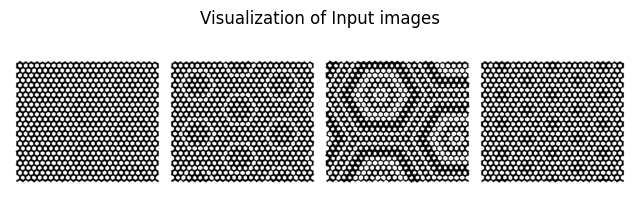

0it [00:00, ?it/s]

sampling time step:   0%|          | 0/96 [00:00<?, ?it/s]

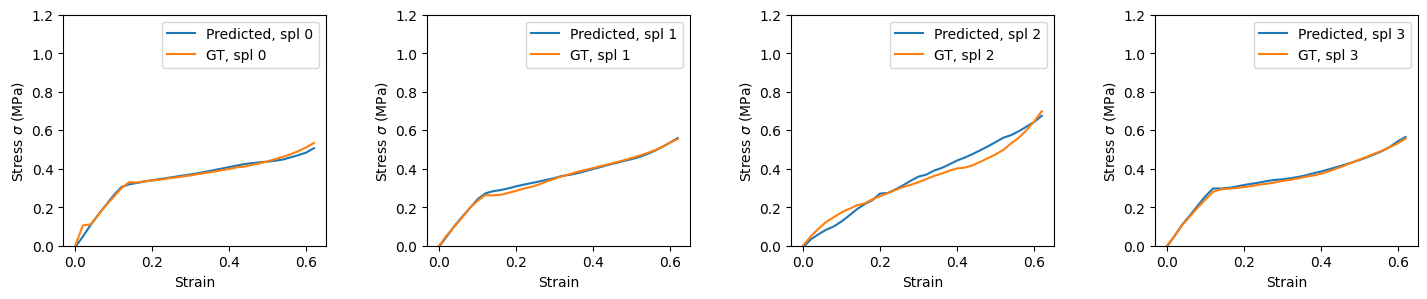

In [32]:
sample_loop (model,
                            test_loader ,
                            cond_scales=[1],#[7.5], #list of cond scales - each sampled...
                            num_samples=4, #how many samples produced every time tested.....
                            timesteps=64,
                                    flag=1000, plot_structure=True, plot_original_data=True,do_forward=False,
             strain=strain,number_batches=1,
                                    )

start sampling


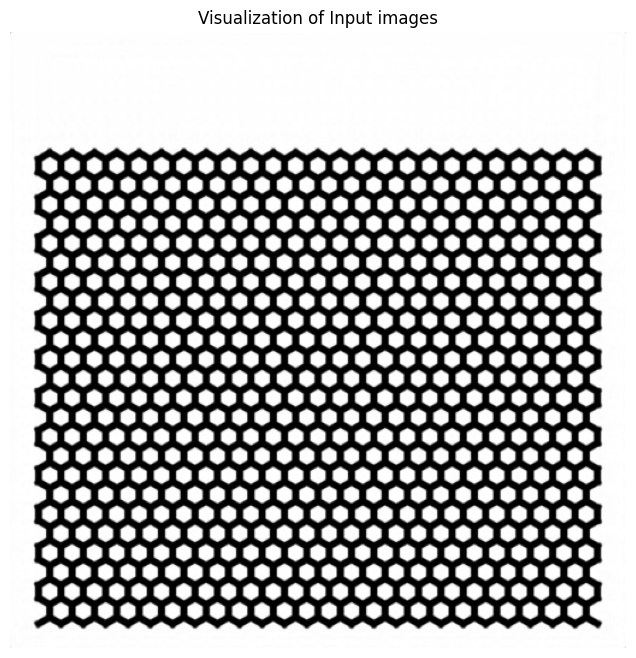

cond scale= 1.0


0it [00:00, ?it/s]

sampling time step:   0%|          | 0/96 [00:00<?, ?it/s]

result shape:  torch.Size([1, 1, 32])
X_train_batch  torch.Size([1, 16, 64])
start sampling


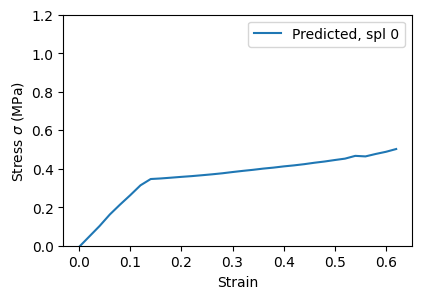

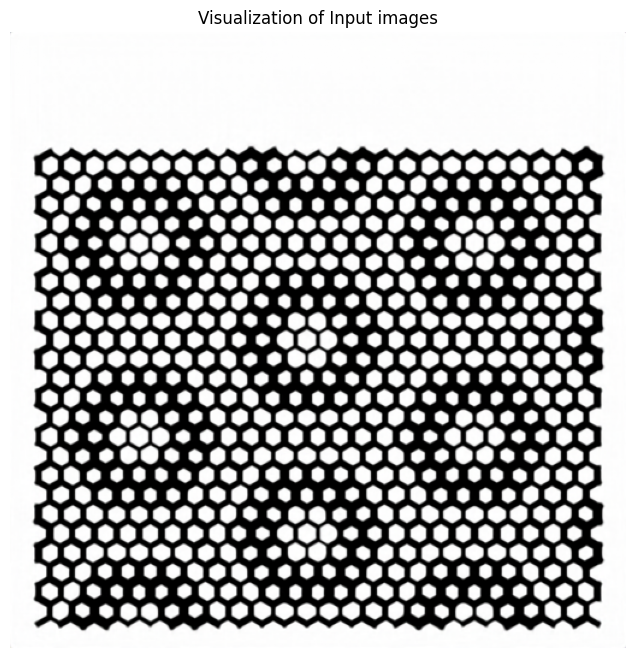

cond scale= 1.0


0it [00:00, ?it/s]

sampling time step:   0%|          | 0/96 [00:00<?, ?it/s]

result shape:  torch.Size([1, 1, 32])
X_train_batch  torch.Size([1, 16, 64])
start sampling


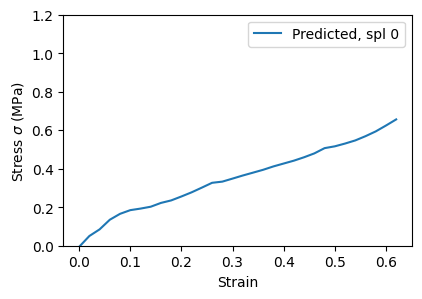

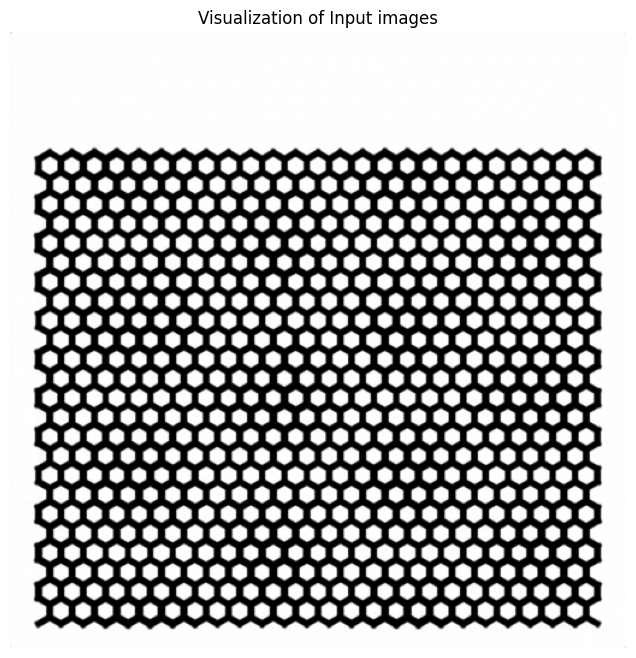

cond scale= 1.0


0it [00:00, ?it/s]

sampling time step:   0%|          | 0/96 [00:00<?, ?it/s]

result shape:  torch.Size([1, 1, 32])
X_train_batch  torch.Size([1, 16, 64])
start sampling


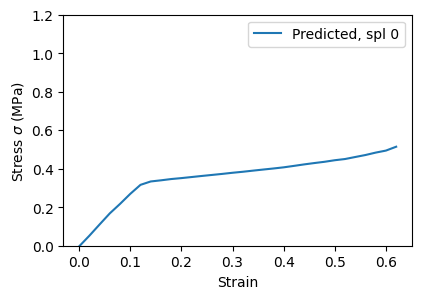

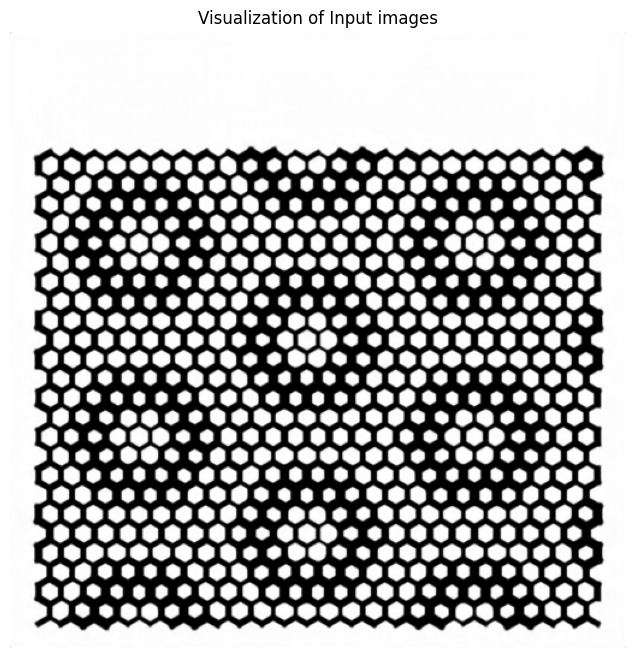

cond scale= 1.0


0it [00:00, ?it/s]

sampling time step:   0%|          | 0/96 [00:00<?, ?it/s]

result shape:  torch.Size([1, 1, 32])
X_train_batch  torch.Size([1, 16, 64])


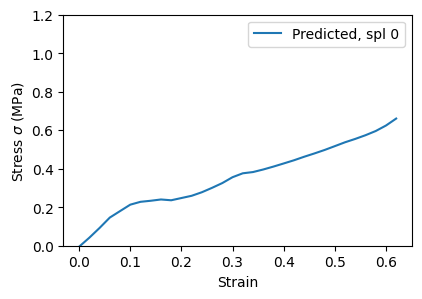

In [51]:
sample_from_image (model=model, fname='../microstructures_for_LAMMPS/recon_samples_40003_1_0.png',
                      GT=None, flag=0, cond_scales=[1.], strain=strain)
sample_from_image (model=model, fname='../microstructures_for_LAMMPS/recon_samples_40003_1_3.png',
                       GT=None, flag=0, cond_scales=[1.], strain=strain)
sample_from_image (model=model, fname='../microstructures_for_LAMMPS/recon_samples_40004_1_0.png',
                      GT=None, flag=0, cond_scales=[1.], strain=strain)
sample_from_image (model=model, fname='../microstructures_for_LAMMPS/recon_samples_40004_1_3.png',
                       GT=None, flag=0, cond_scales=[1.], strain=strain)